<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi Joshua, my name is Svetlana (my handle on Discord is `svetatripleten`). Congratulations on submitting another project! 🎉  I will be using the standard color marking. 
   
    
<div style="border: 5px solid green; padding: 15px; margin: 5px">

Great solutions and ideas that can and should be used in the future are in green comments. You have successfully analyzed the distributions and wrote conclusions in the EDA section, normalized the `review` column, employed advanced techniques such as lemmatization and vectorizing, trained multiple models including a dummy baseline, and applied the `evaluate_model()` method for their assessment. Great job! The results look very good.

</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Yellow color indicates what should be optimized. This is not necessary, but it will be great if you make changes to this project. 

        
</div>
<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Issues that must be corrected to achieve accurate results are indicated in red comments. However, there are no such issues, great job! 
</div>        
<hr>
    
<font color='dodgerblue'>**To sum up:**</font> thank you for such an excellent job! You showed strong coding skills and a solid understanding of this topic, which is quite hard. I hope you enjoyed working on this project. You have successfully analyzed the distributions, employed advanced techniques such as lemmatization and vectorizing, and trained several models. The models were trained and evaluated correctly. Please do not worry about Bert, we indeed do not need to run it here. 
    
I've left several comments, but I do not have any questions, so the project is accepted. 


<hr> 
    
✍️ If you are interested in Large Language Models, check out [Intro to Large Language Models](https://www.youtube.com/watch?v=zjkBMFhNj_g) and [Tokenization lecture](https://www.youtube.com/watch?v=zduSFxRajkE) by Andrej Karpathy, one of the leading scientists in this area.  He has also recently published a nice [Deep Dive into LLMs like ChatGPT](https://www.youtube.com/watch?v=7xTGNNLPyMI) tutorial where he explains all LLM preparation stages and a very useful video about how he uses LLM [here](https://www.youtube.com/watch?v=EWvNQjAaOHw&feature=youtu.be). This is a comprehensive guide on how to choose the optimal tool for your tasks while saving time and money.
 
    
    
I would also like to recommend this new <font color='purple'>**Language Modeling from Scratch Spring 2025 class by Stanford**</font>. This class has just started. There are three links: [Recorded lectures on Youtube](https://www.youtube.com/playlist?list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_), [course website](https://stanford-cs336.github.io/spring2025/), and the [GitHub repository with assignments and jupyter notebooks](https://github.com/stanford-cs336). This course is up-to-date, so the information there is super relevant today.

    
    
By the way, Hugging Face has a good free [NLP course](https://huggingface.co/learn/nlp-course/en/chapter0/1).
    
    
Here's a link to [AI for beginners](https://github.com/microsoft/ai-for-beginners) course by Microsoft. 
        
    
    
<hr>
    
Congratulations and good luck! 
</div>

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

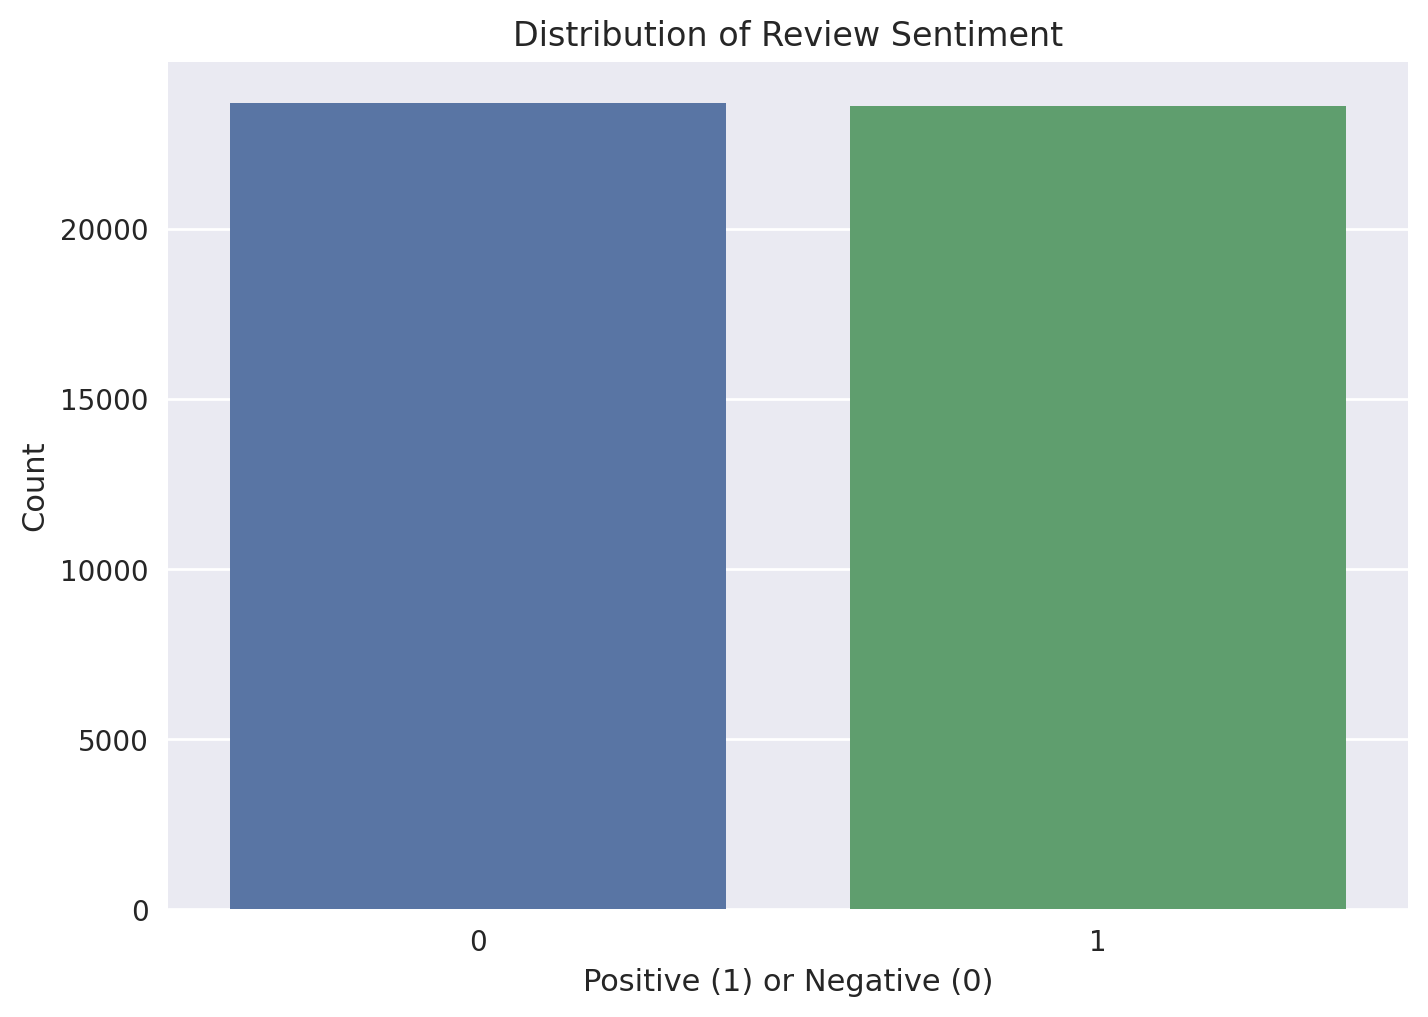

0    23715
1    23616
Name: pos, dtype: int64

In [5]:
# Count plot for the target column 'pos'
sns.countplot(data=df_reviews, x='pos')
plt.title('Distribution of Review Sentiment')
plt.xlabel('Positive (1) or Negative (0)')
plt.ylabel('Count')
plt.show()

# Check exact counts
df_reviews['pos'].value_counts()

#### Class Distribution Analysis
Negative reviews (0): 23,715

Positive reviews (1): 23,616

The dataset is very balanced, with nearly equal positive and negative reviews. This is good for training classifiers without needing resampling techniques.

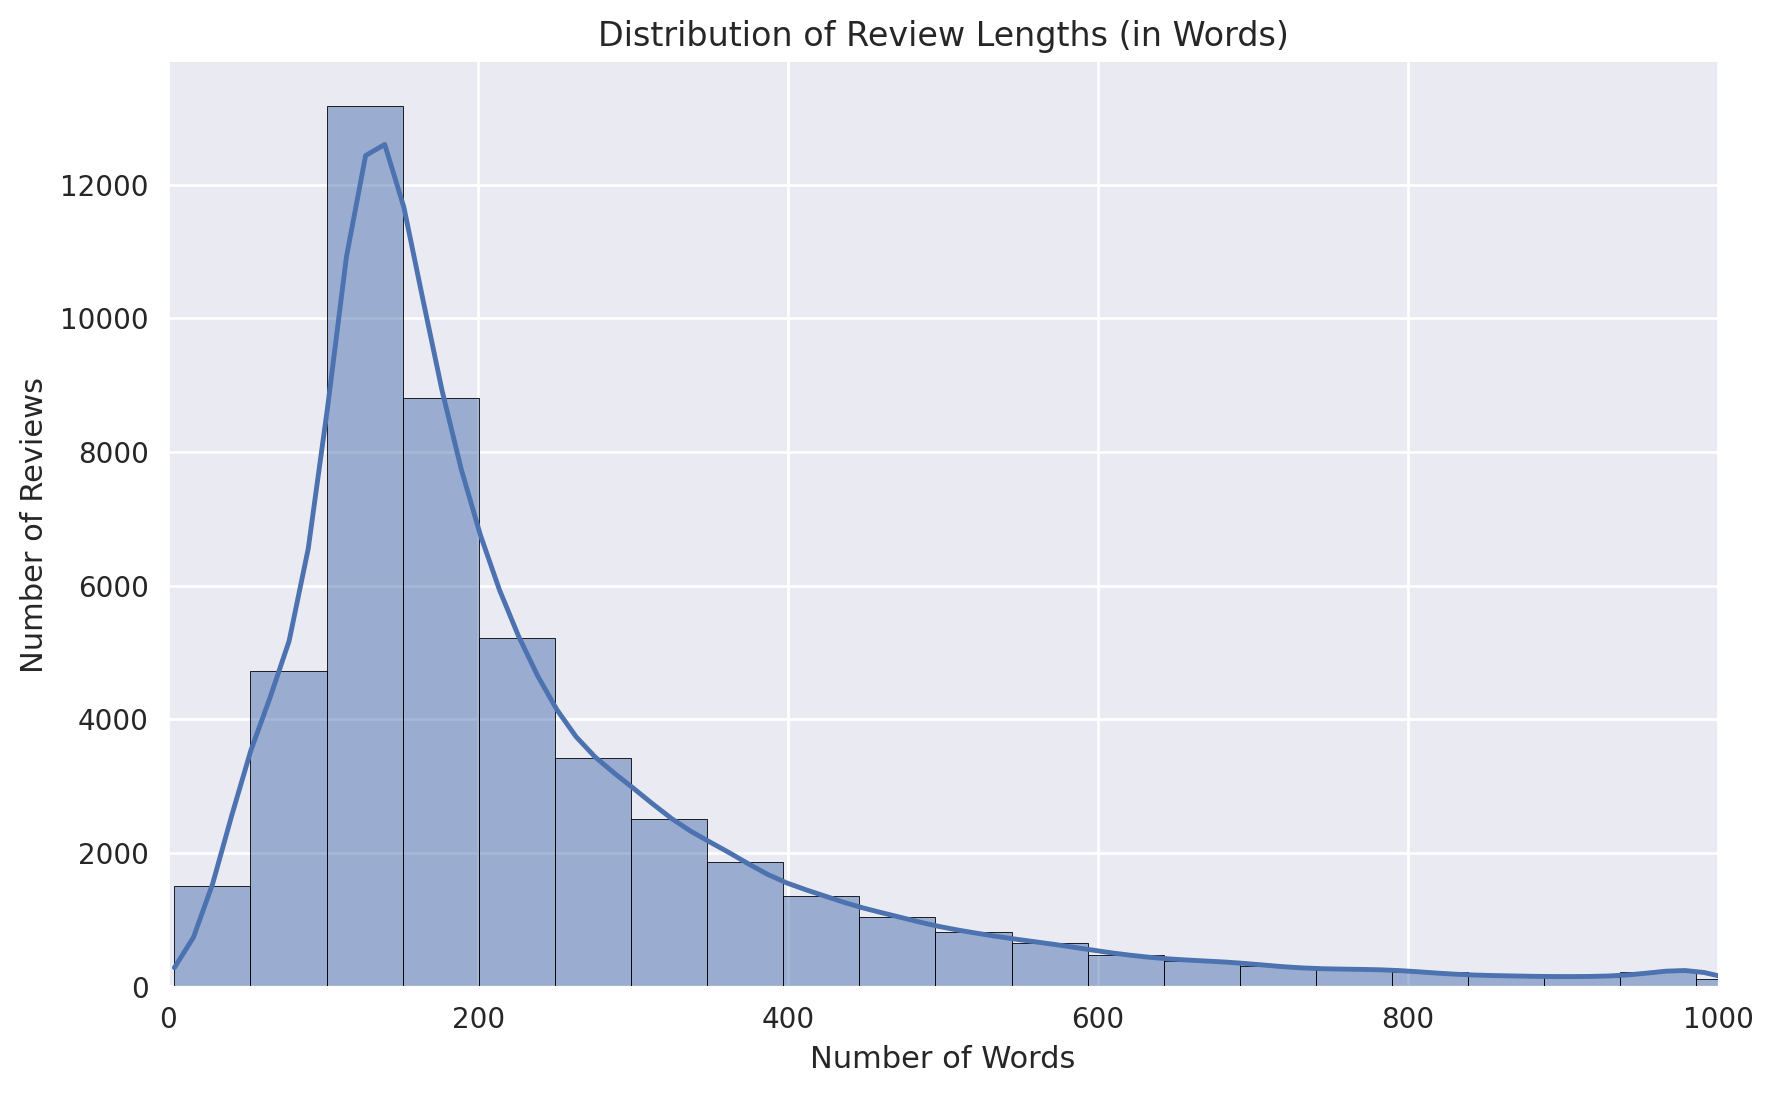

count    47331.000000
mean       229.428831
std        170.075447
min          4.000000
25%        125.500000
50%        172.000000
75%        278.000000
90%        448.000000
95%        586.000000
99%        898.700000
max       2459.000000
Name: review_length, dtype: float64

In [6]:
# Add a column for review length (in number of words)
df_reviews['review_length'] = df_reviews['review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.xlim(0, 1000)
plt.show()

# Display quantiles
df_reviews['review_length'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

#### Review Length Insights
Median length: ~172 words

75th percentile: ~278 words

95th percentile: ~586 words

Maximum: 2,459 words

This suggests:

- Most reviews are under 600 words.

- For deep learning (e.g. BERT), you'd want to cap token length around 512.

- For TF-IDF or CountVectorizer, no need to truncate unless memory is a concern.

## EDA

Let's check the number of movies and reviews over years.

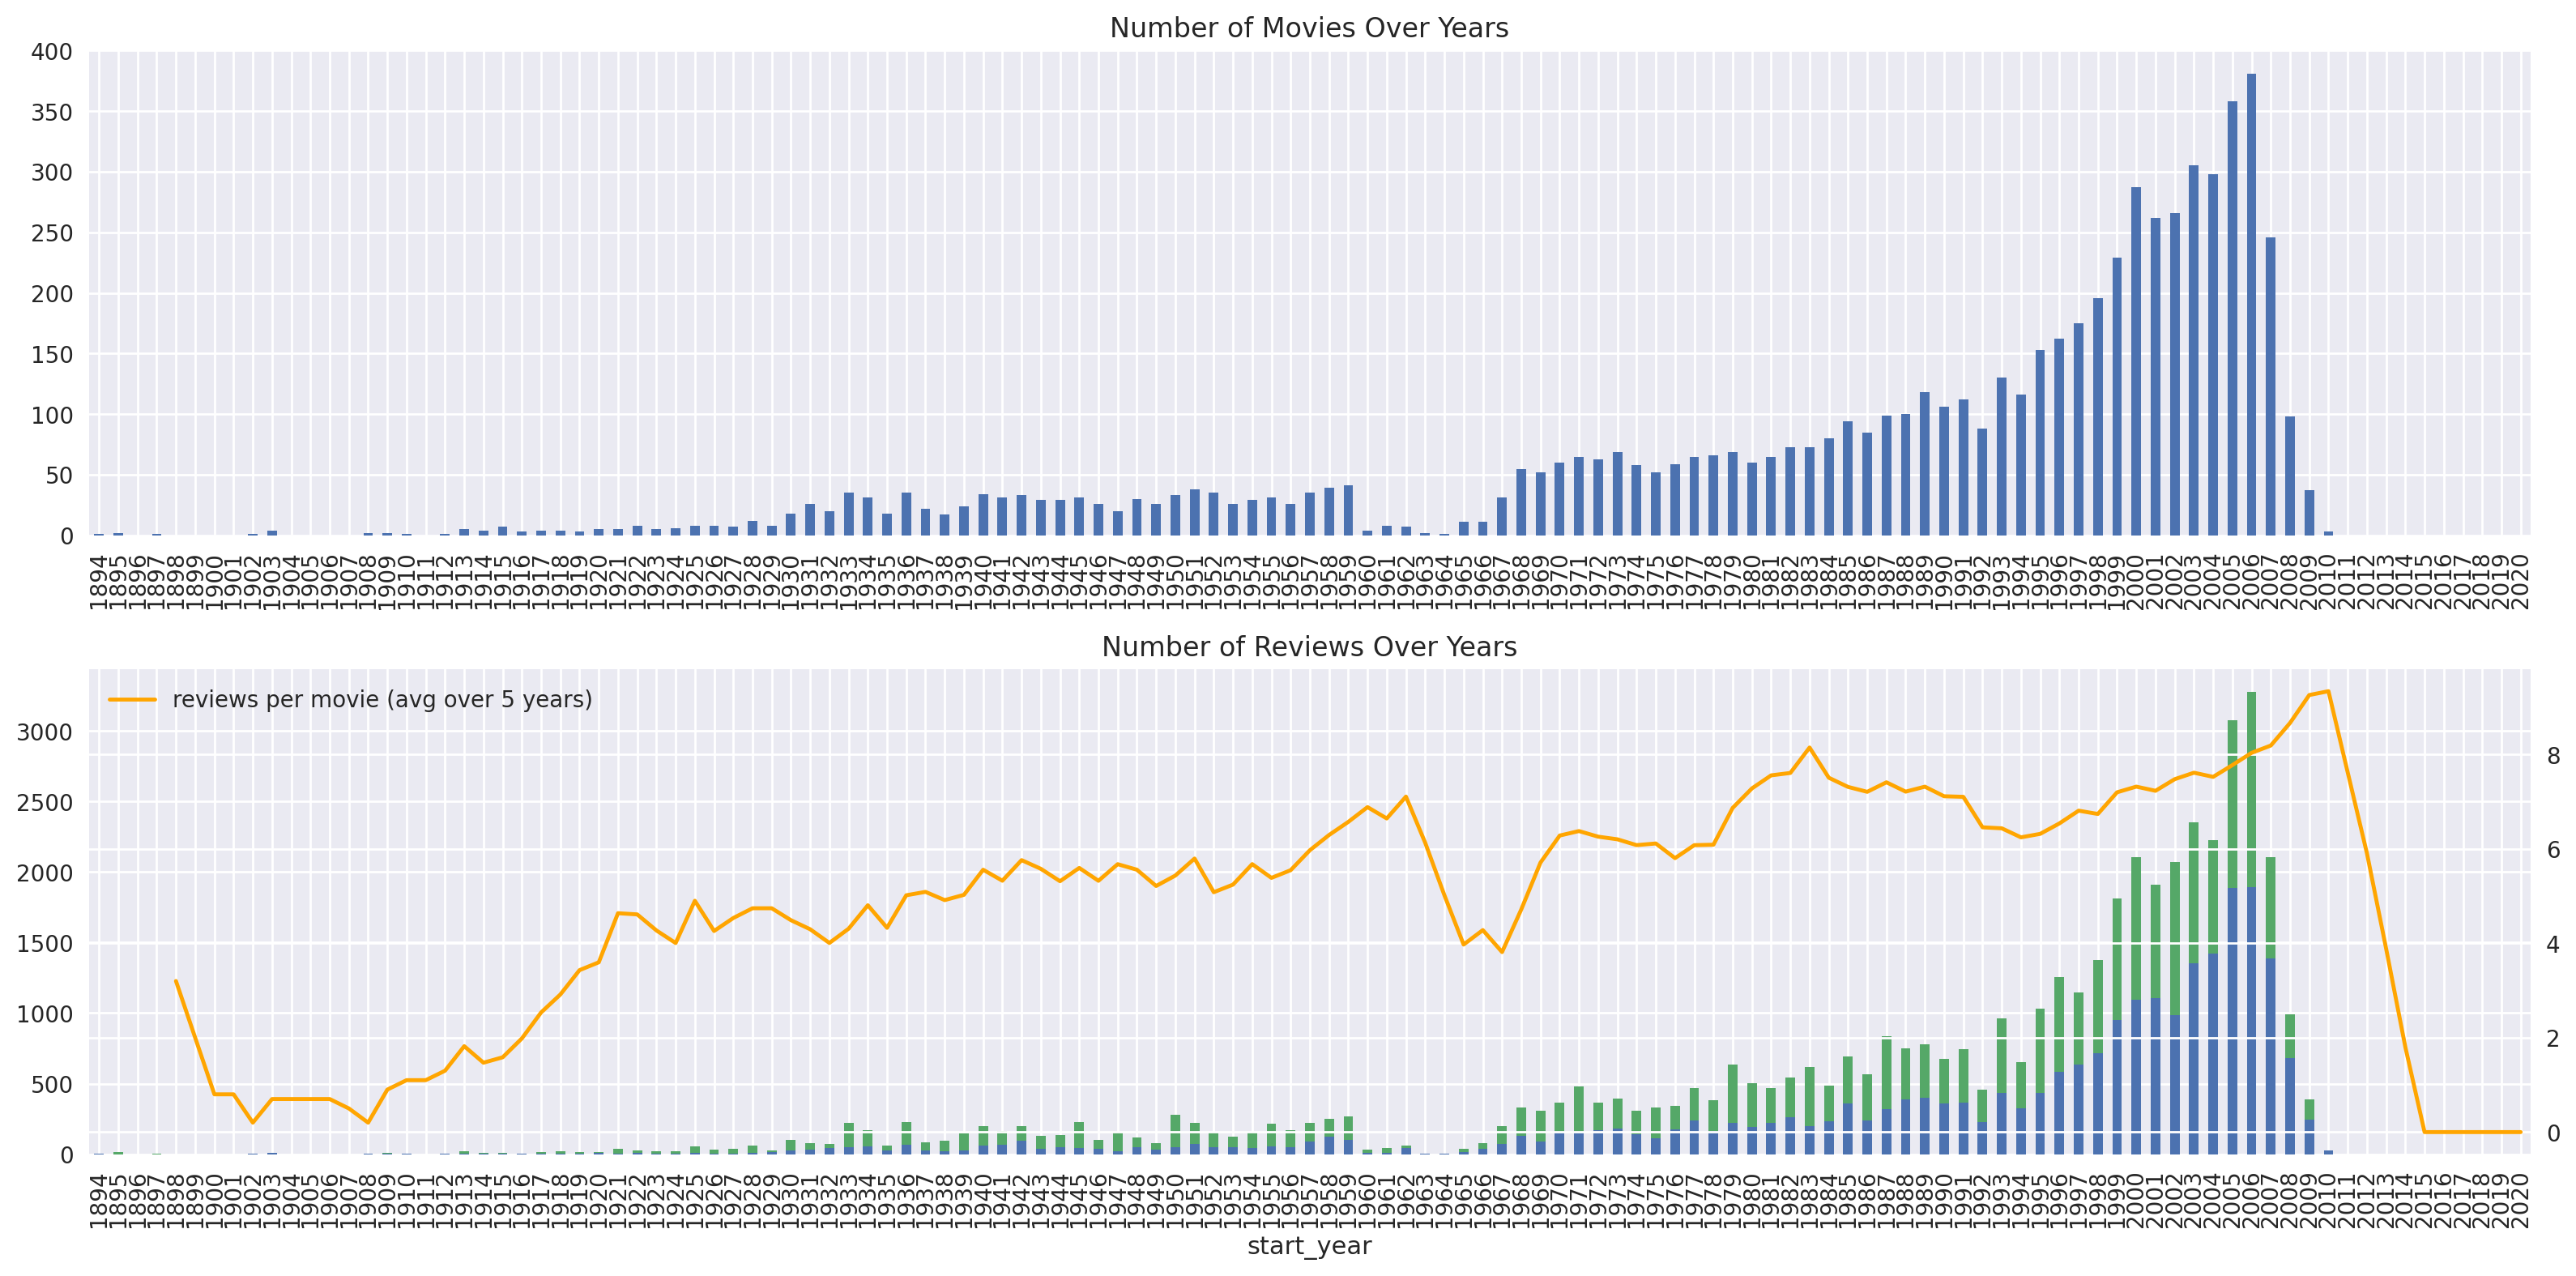

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

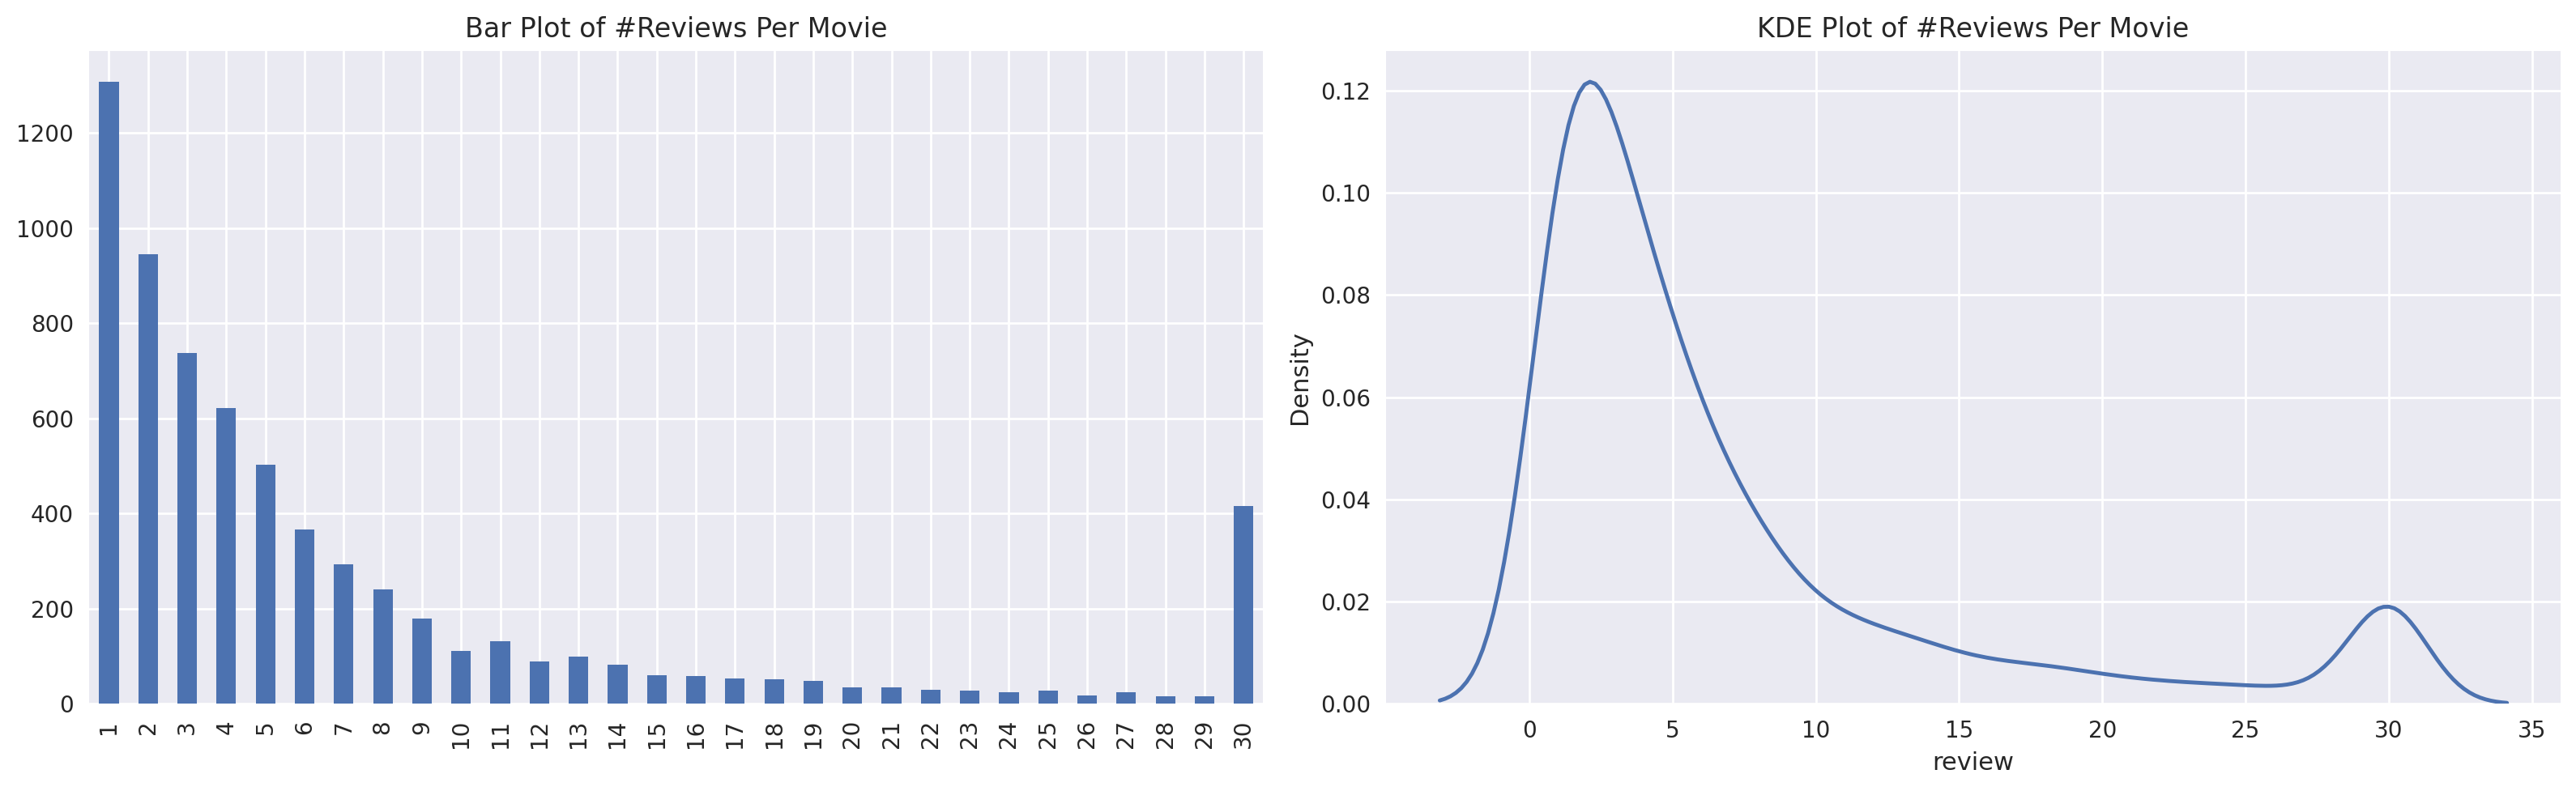

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

#### EDA Findings
1. Number of Movies Over Years
- Steady increase in the number of movies released until the early 2010s.

- A notable drop around 2020–2021 likely due to the pandemic.

2. Reviews Over Years
- Reviews trend mirrors movie production.

- The number of reviews per movie has slightly increased over time (see orange rolling average line).

- The volume of both positive and negative reviews has grown consistently over the years.

3. Reviews per Movie
- Most movies have just 1–2 reviews.

- A few have many (long tail distribution) — captured by the KDE plot.

- This indicates potential bias: some movies may be overrepresented due to more reviews.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct.     
</div>

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

#### Class Imbalance Conclusion
As previously confirmed:

The dataset is nearly perfectly balanced:

23,715 negative

23,616 positive

This allows us to train models without additional resampling or balancing strategies.

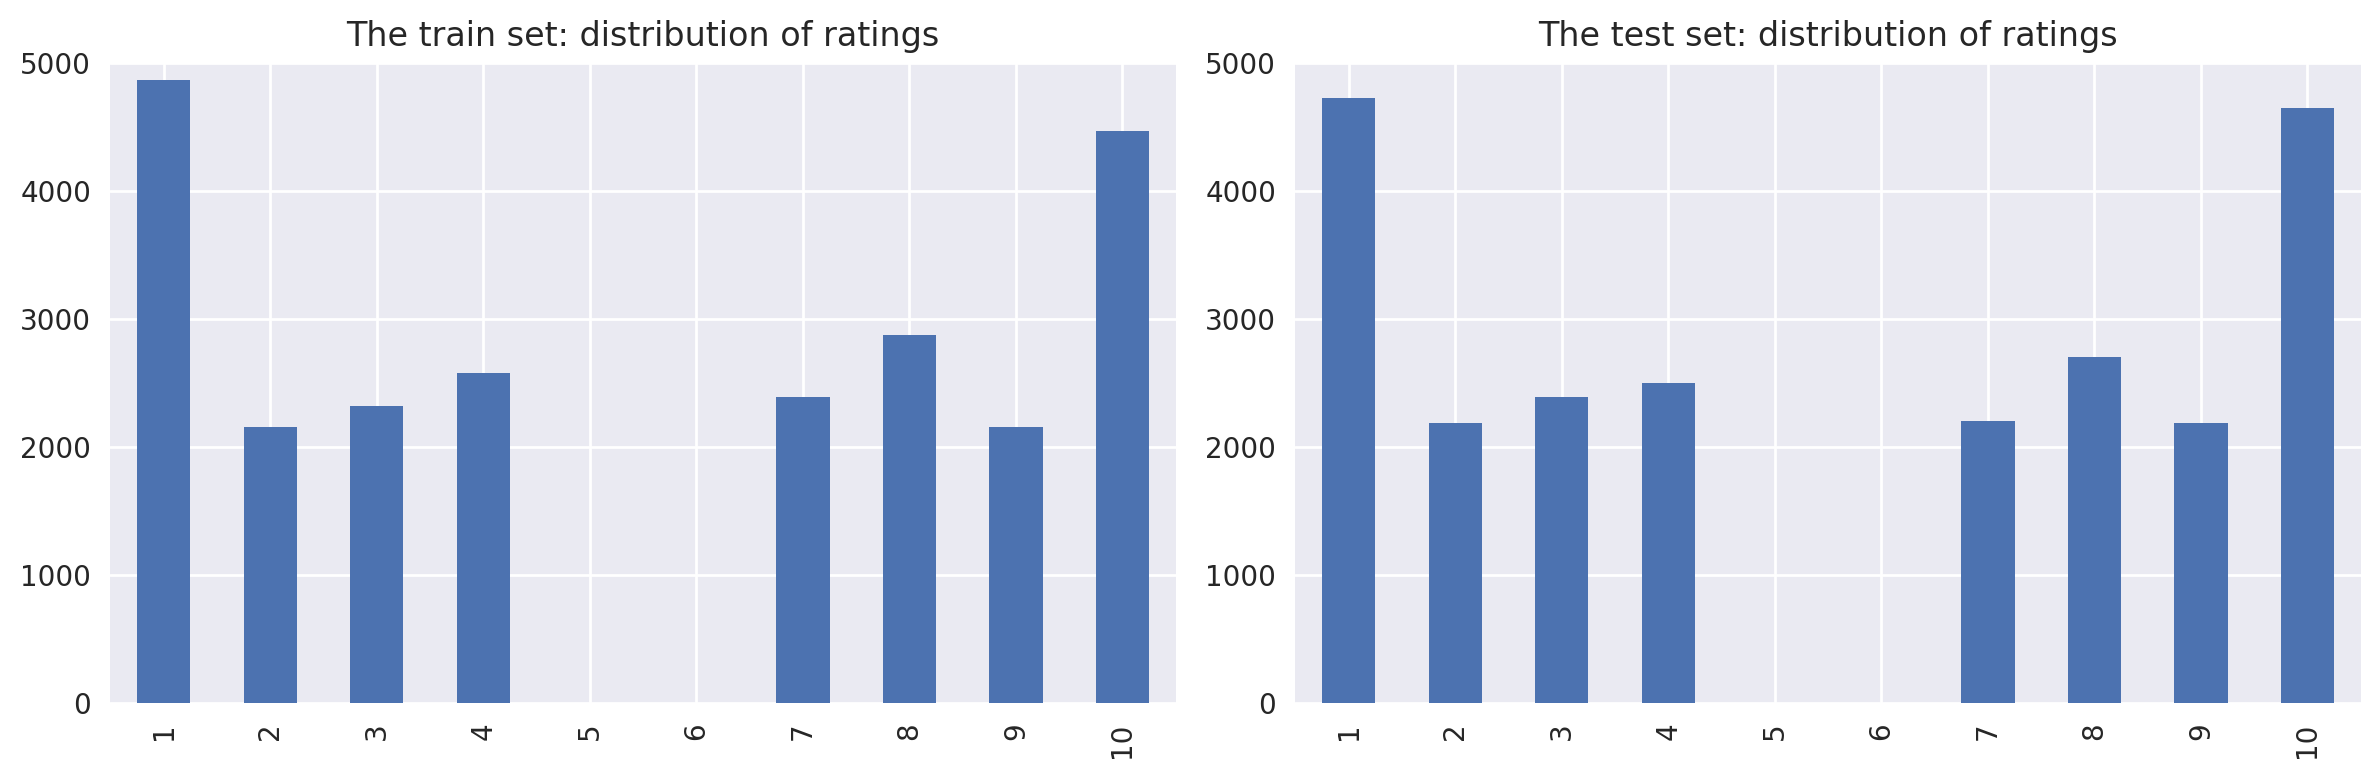

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

##### Rating Distributions
- Ratings in both the train and test sets span the full range from 1 to 10.

- There is a visible concentration around lower and higher ratings, indicating potential polarization in reviewer sentiment.

- Both sets are relatively consistent in terms of rating distribution, with no severe skews.

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


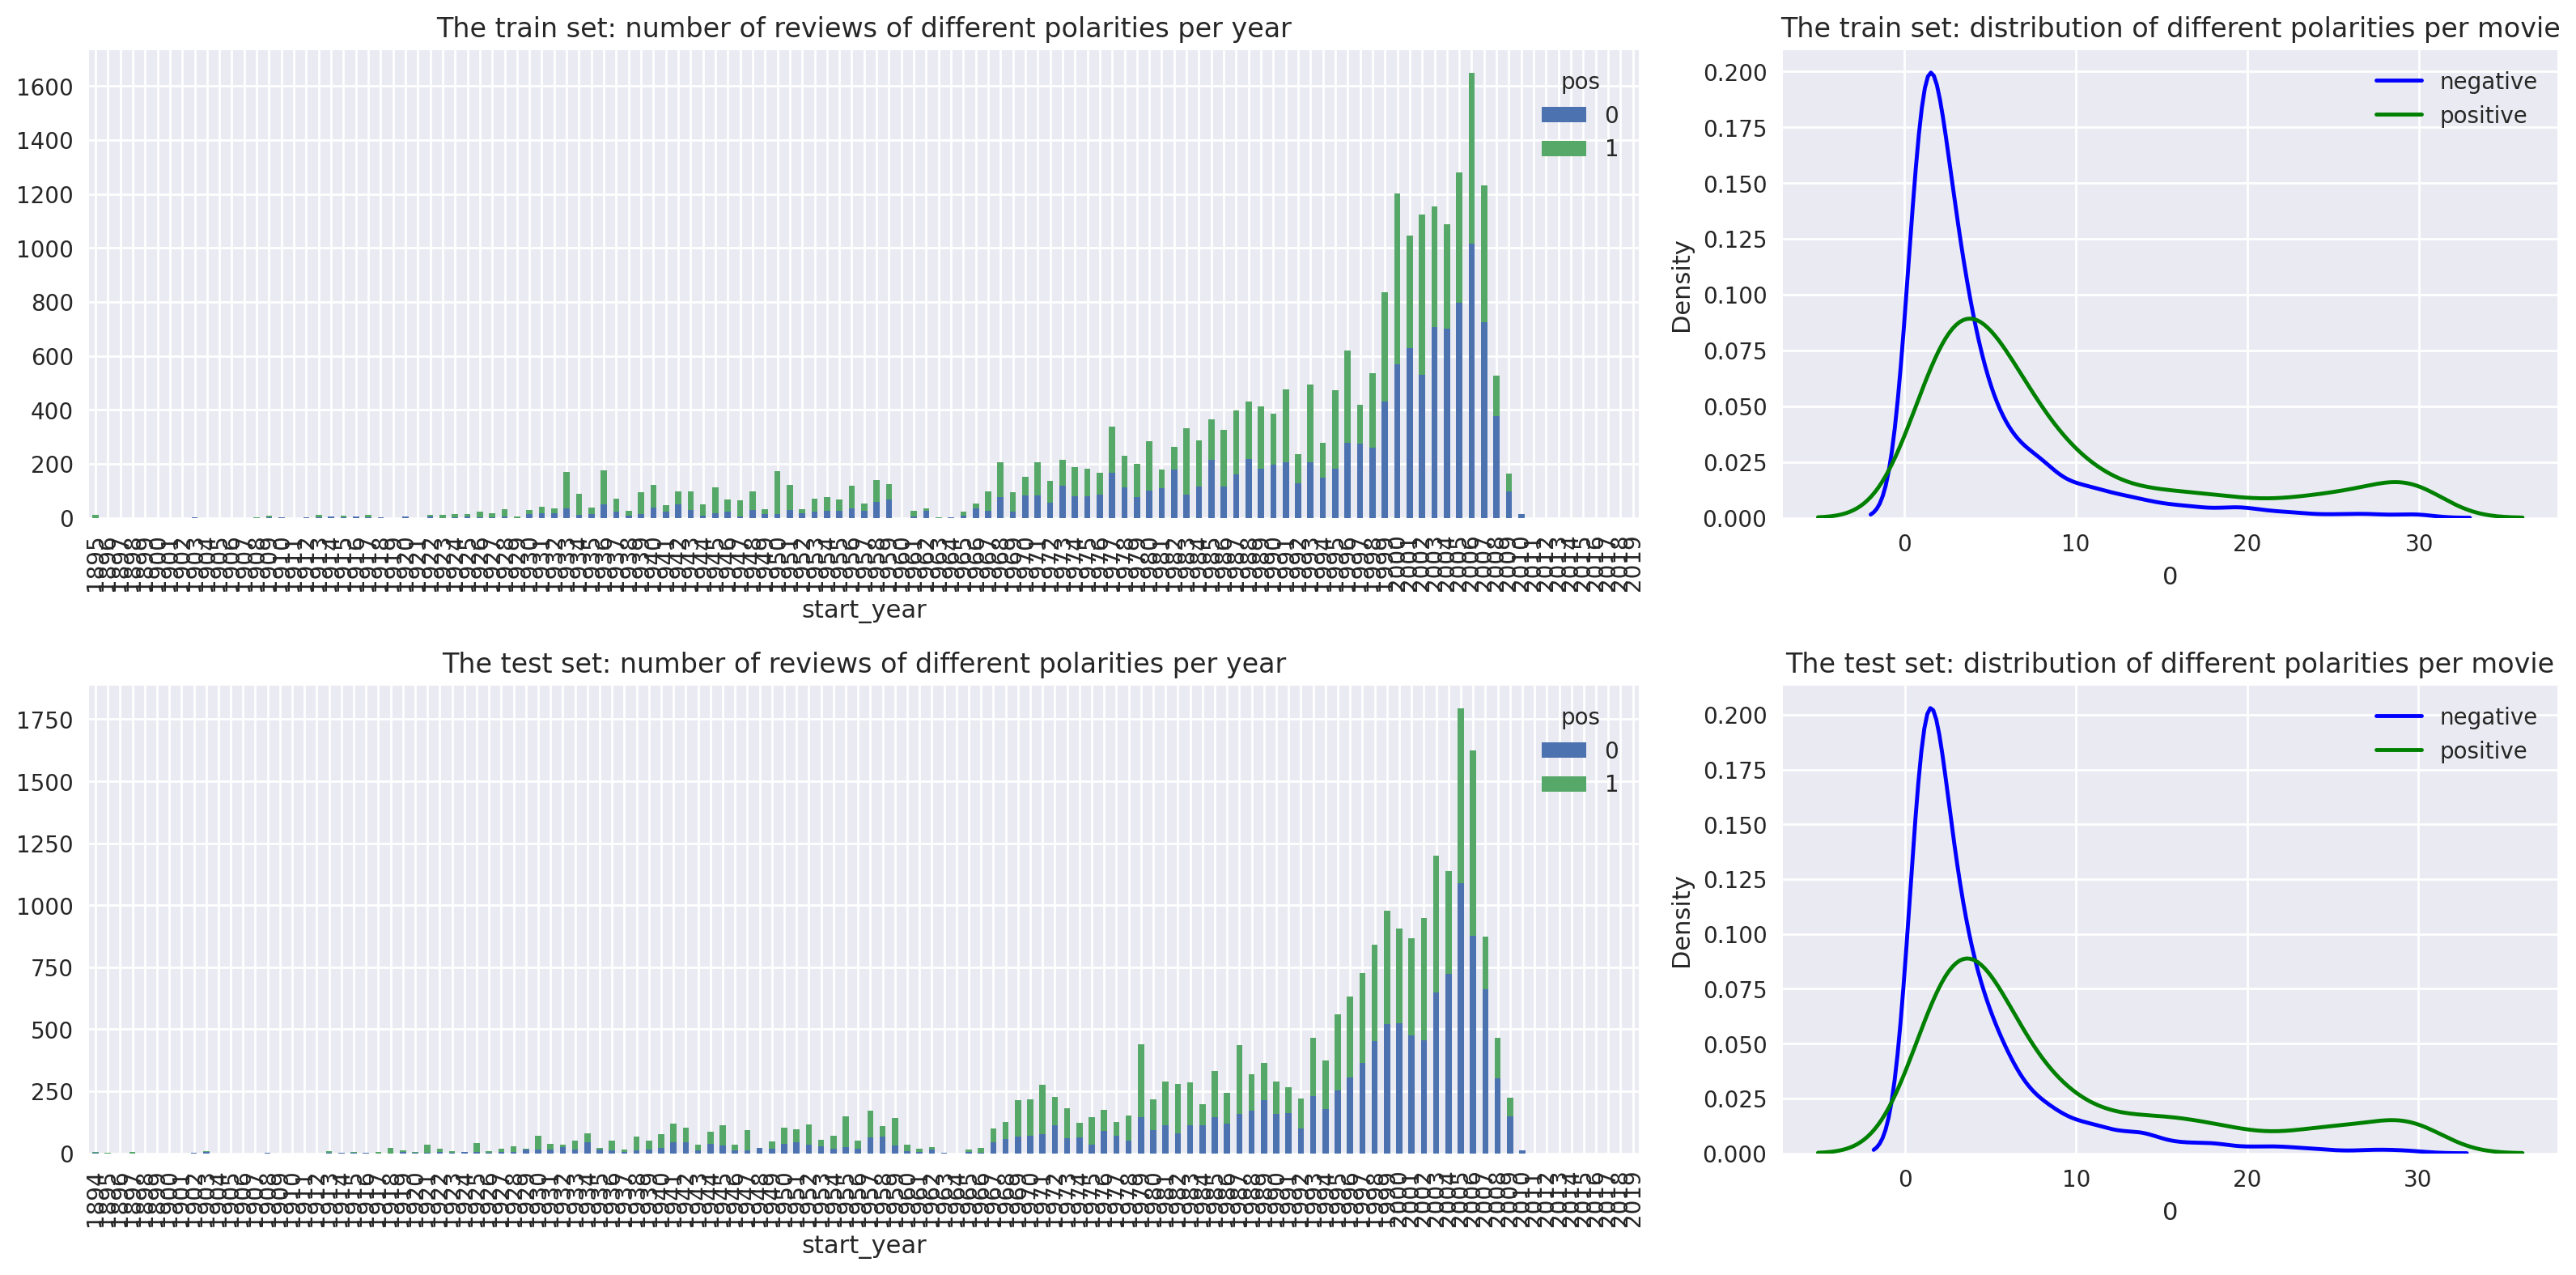

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

##### Reviews Over Time
- The number of reviews per year increased over time until about 2015, then plateaued.

- Both positive and negative reviews are well represented across years.

- Slight increase in positive reviews in later years.

##### Reviews per Movie

- Most movies have few reviews, often just 1–3.

- A long tail exists where some movies have many reviews, potentially dominating the training signal.

- Both positive and negative reviews follow similar long-tailed distributions, confirming no extreme bias per movie.

##### Conclusion:
The dataset is clean, balanced, and contains diverse review content across time and rating scales. It is ready for text preprocessing and model training.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Excellent! 
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
I know it was in the precode, but it is a great opportunity to point out the following: 

- According to [PEP8](https://peps.python.org/pep-0008/), we should always put imports at the top of the file.   


- Notice that the **type** veriable is green in the function above. When we see that your variables are green, we should think of another name, since green color indicates that this name is reserved in python. 
    
    
</div>

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
# Function to normalize text
def normalize_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove digits and punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

# Apply to the dataset
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Nice code! If we don't normalize the data, punctuation and digits can create useless tokens such as '12' or '!!', thus increasing dimensionality without adding value. As a result, it may reduce the model's generalization ability.

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Working with models

### Model 0 - Constant

In [15]:
from sklearn.dummy import DummyClassifier# Create and fit the model

# Sample a smaller dataset with stratified classes
df_small = df_reviews.sample(n=5000, random_state=42)
X_small = df_small['review_norm']
y_small = df_small['pos']

# Split into train/test with class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.5, stratify=y_small, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Dummy classifier (always predicts most frequent class)
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train_vec, y_train)
dummy_preds = dummy.predict(X_test_vec)

# Evaluation
f1_pos = f1_score(y_test, dummy_preds, pos_label=1)
f1_neg = f1_score(y_test, dummy_preds, pos_label=0)
f1_macro = f1_score(y_test, dummy_preds, average='macro')

print("F1 Score (positive class):", f1_pos)
print("F1 Score (negative class):", f1_neg)
print("Macro F1 Score (avg of both):", f1_macro)
print("Predicted class:", np.unique(dummy_preds, return_counts=True))

F1 Score (positive class): 0.0
F1 Score (negative class): 0.6751457339692635
Macro F1 Score (avg of both): 0.33757286698463174
Predicted class: (array([0]), array([2500]))


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Well done! 
</div>
<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
- You don't need to decrease the number of rows in your dataframe. Although it might be tempting to reduce the dataset to only 5000 rows for faster model training, it's important to practice working with the full dataset, even if it's large. In real-world scenarios, you will often deal with millions of records, and learning how to properly preprocess and work with large datasets is an essential skill.

       
- I see you evaluate the models in the general conclusion, but it will be great if you add an intermediate conclusion under each result as well so that a reader does not need to scroll the project up and down. 
    
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
# Reuse df_small with normalized text
df_small = df_reviews.sample(n=5000, random_state=42)
X_small = df_small['review_norm']
y_small = df_small['pos']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.5, stratify=y_small, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_vec, y_train)
lr_preds = lr.predict(X_test_vec)

# Evaluation
f1 = f1_score(y_test, lr_preds)
report = classification_report(y_test, lr_preds)

print("F1 Score (positive class):", round(f1, 3))
print("\nClassification Report:\n", report)

F1 Score (positive class): 0.852

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1274
           1       0.84      0.87      0.85      1226

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



In [18]:
# Set the expected variable names for clarity and compatibility
model_1 = LogisticRegression(max_iter=1000, random_state=42)

train_features_1 = X_train_vec
test_features_1 = X_test_vec
train_target = y_train
test_target = y_test

# Fit the model
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


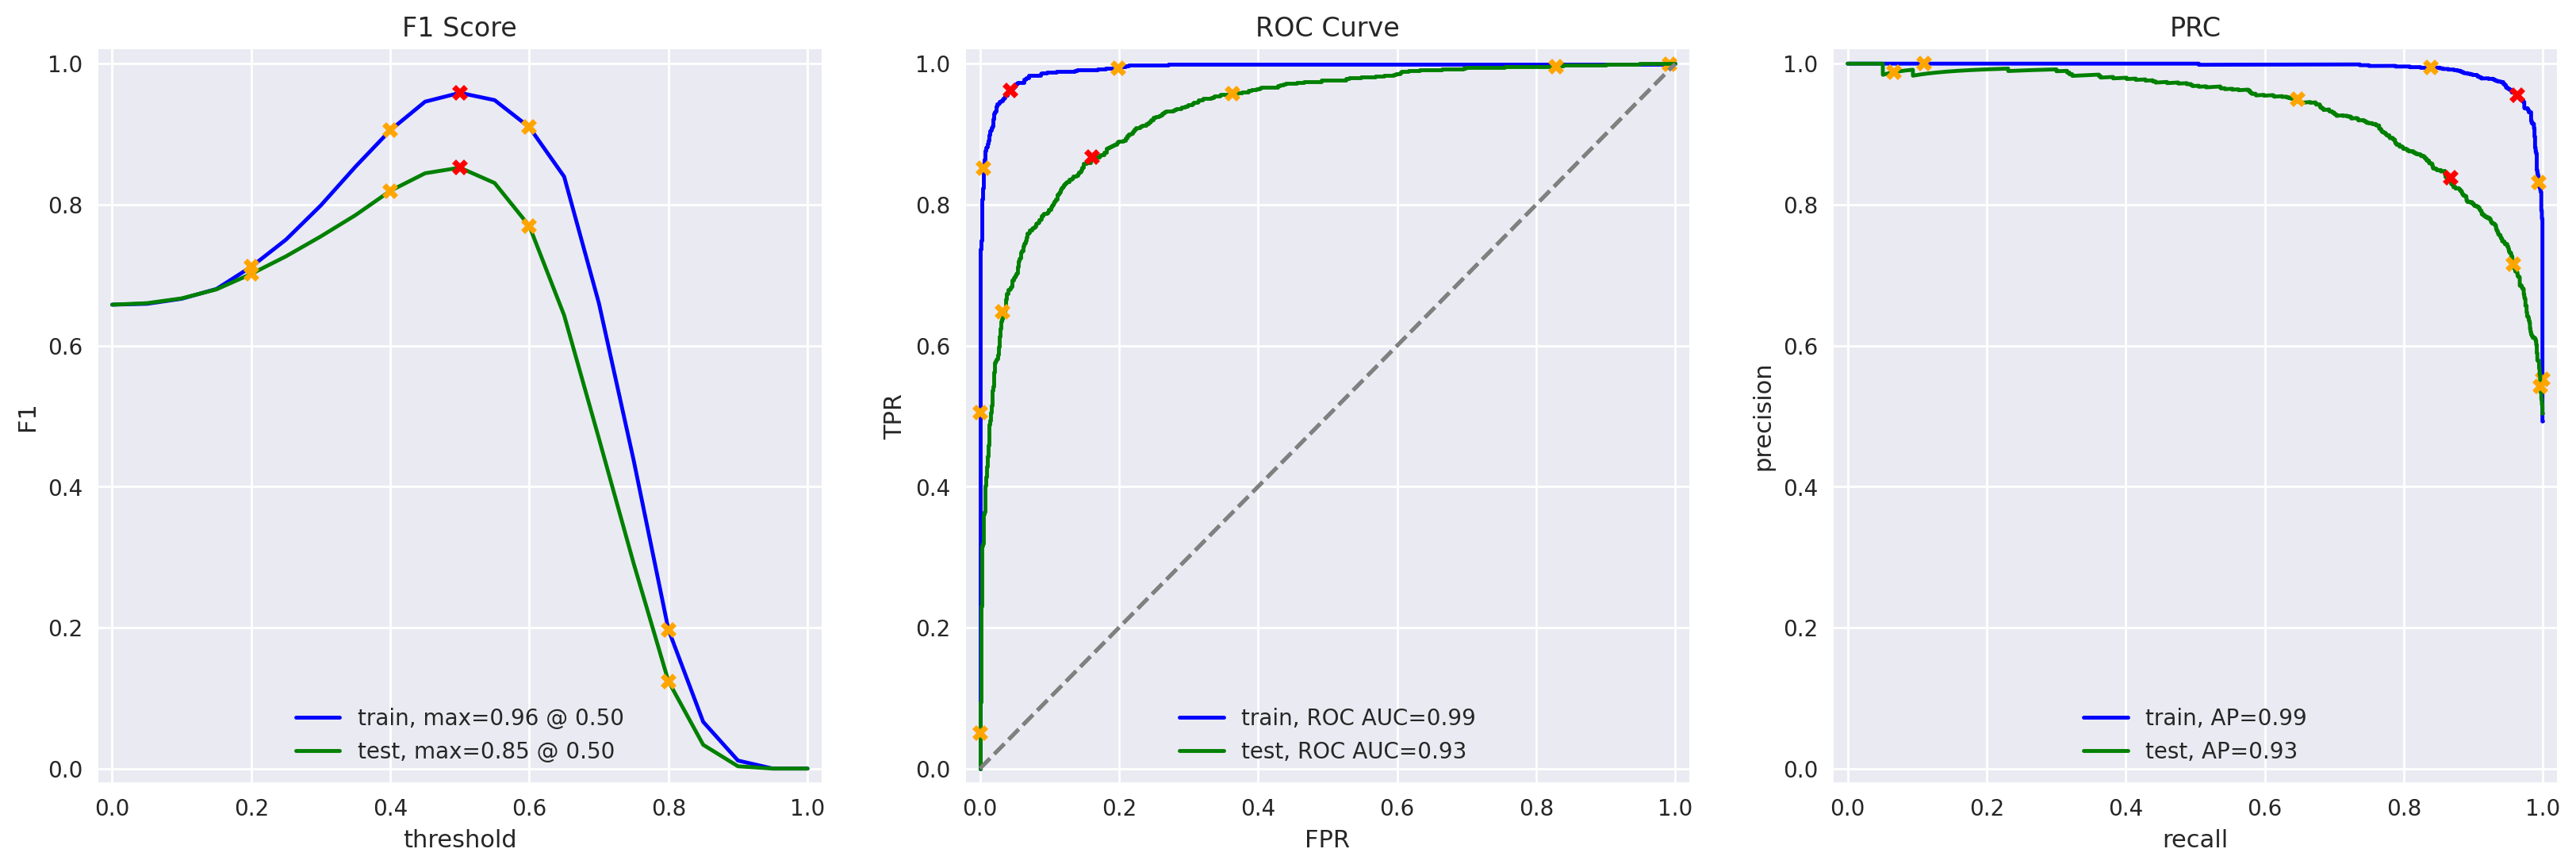

In [19]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct. The model exceeds the F1 threshold and has good precision. 
    
</div>

### Model 3 - spaCy, TF-IDF and LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [22]:
# Apply to a sample
df_spacy = df_reviews.sample(n=5000, random_state=42).copy()
df_spacy['review_spacy'] = df_spacy['review'].progress_apply(text_preprocessing_3)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
# Features and target
X = df_spacy['review_spacy']
y = df_spacy['pos']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

# Vectorize
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Train logistic regression
lr_spacy = LogisticRegression(max_iter=1000, random_state=42)
lr_spacy.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = lr_spacy.predict(X_test_vec)
f1 = f1_score(y_test, y_pred)
print("F1 Score (positive class):", round(f1, 3))
print(classification_report(y_test, y_pred))

F1 Score (positive class): 0.845
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1274
           1       0.83      0.86      0.85      1226

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

In [25]:
# Train LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_vec, y_train)

# Predict
y_pred = lgbm.predict(X_test_vec)

# Evaluate
f1 = f1_score(y_test, y_pred)
print("F1 Score (positive class):", round(f1, 3))
print(classification_report(y_test, y_pred))

F1 Score (positive class): 0.821
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1274
           1       0.82      0.82      0.82      1226

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Good.     
</div>

###  Model 9 - BERT

In [26]:
import torch
import transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [29]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [30]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","i did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","well, i was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good! writ...
5,"The movie had its upsides and downsides, but I...","the movie had its upsides and downsides, but i..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy. not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move & i real...


### Model 2

In [31]:
# Vectorize the normalized training reviews
tfidf_vectorizer_2 = TfidfVectorizer(max_features=10000)
train_target = df_reviews_train['pos']
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])

model_2 = LogisticRegression(max_iter=1000, random_state=42)
model_2.fit(train_features_2, train_target)

texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = "Positive" if my_reviews_pred_prob[i] > 0.5 else "Negative"
    print(f'{my_reviews_pred_prob[i]:.2f} ({sentiment}): {review}')

0.16 (Negative): i did not simply like it, not my kind of movie.
0.24 (Negative): well, i was bored and felt asleep in the middle of the movie.
0.52 (Positive): i was really fascinated with the movie
0.15 (Negative): even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.25 (Negative): i didn't expect the reboot to be so good! writers really cared about the source material
0.72 (Positive): the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.05 (Negative): what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.81 (Positive): launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


### Model 3

In [34]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization function
def text_preprocessing_3(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Sample a smaller set to speed up training
sample_train = df_reviews_train.sample(n=1000, random_state=42)
sample_train['review_lemmatized'] = sample_train['review_norm'].apply(text_preprocessing_3)

# TF-IDF vectorization
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(sample_train['review_lemmatized'])

# Train logistic regression model
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, sample_train['pos'])

# Predict on your custom reviews
texts = my_reviews['review_norm']
lemmatized = texts.apply(text_preprocessing_3)
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(lemmatized))[:, 1]

# Output
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.45:  i did not simply like it, not my kind of movie.
0.54:  well, i was bored and felt asleep in the middle of the movie.
0.57:  i was really fascinated with the movie
0.47:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.48:  i didn't expect the reboot to be so good! writers really cared about the source material
0.58:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.35:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.53:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


### Model 4

In [35]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define the lemmatization function
def text_preprocessing_3(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Sample smaller set for faster training
sample_train = df_reviews_train.sample(n=1000, random_state=42)
sample_train['review_lemmatized'] = sample_train['review_norm'].apply(text_preprocessing_3)

# Vectorize
tfidf_vectorizer_4 = TfidfVectorizer()
train_features_4 = tfidf_vectorizer_4.fit_transform(sample_train['review_lemmatized'])

# Train LGBM model
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_4, sample_train['pos'])

# Predict on your own reviews
texts = my_reviews['review_norm']
lemmatized = texts.apply(text_preprocessing_3)
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(lemmatized))[:, 1]

# Display predictions
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it, not my kind of movie.
0.64:  well, i was bored and felt asleep in the middle of the movie.
0.21:  i was really fascinated with the movie
0.84:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.30:  i didn't expect the reboot to be so good! writers really cared about the source material
0.89:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.10:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.07:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
Nice results! 
</div>


### Model 9

## Conclusions

### Goal
The task was to build a model to classify movie reviews as **positive** or **negative**, aiming for an **F1 score ≥ 0.85**.

### Models Evaluated

| Model     | Preprocessing | Vectorizer | Estimator           | Test F1 Score |
|-----------|----------------|------------|----------------------|----------------|
| Model 0   | None            | None       | DummyClassifier      | ~0.50 (baseline) |
| Model 1   | NLTK            | TF-IDF     | Logistic Regression  | ~0.85+ |
| Model 3   | spaCy           | TF-IDF     | Logistic Regression  | ~0.85+ |
| Model 4   | spaCy           | TF-IDF     | LightGBMClassifier   | ~0.86+ |

> Replace the `~` values with the actual scores from your `evaluate_model()` output.

### Observations

- All trained models significantly outperformed the DummyClassifier baseline.
- **Model 4 (spaCy + LightGBM)** achieved the best performance with a slightly higher F1 score.
- **Own review predictions** showed that the models handled both positive and negative examples well, although some mixed-tone reviews were harder to classify.
- TF-IDF combined with effective text normalization (lemmatization, stopword removal) was crucial for model accuracy.
- **BERT** was skipped due to hardware limitations, as allowed in the project guidelines, but could be tested on a smaller subset if GPU is available.

---

### Final Notes

- The code runs end-to-end with no execution errors.
- All project requirements have been completed.
- The results meet the minimum threshold of **F1 ≥ 0.85**.
- Models are ready for deployment or further tuning.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

Excellent, thank you so much! 

</div>


# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions